# Churn Telecom Modeling Process

-This is our initial notebook where we will begin EDA and preprocess our data for a baseline model.

## First off necessary import statements aggregated together.

In [83]:
import folium
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.set_option('display.max_columns', 300)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
%matplotlib inline
warnings.filterwarnings("ignore")

In [55]:
org_df=pd.read_csv('data/churn-data-set.csv').drop('phone number', axis =1)
org_df.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,no,yes,25,265.10,110,45.07,197.40,99,16.78,244.70,91,11.01,10.00,3,2.70,1,False
1,OH,107,415,no,yes,26,161.60,123,27.47,195.50,103,16.62,254.40,103,11.45,13.70,3,3.70,1,False
2,NJ,137,415,no,no,0,243.40,114,41.38,121.20,110,10.30,162.60,104,7.32,12.20,5,3.29,0,False
3,OH,84,408,yes,no,0,299.40,71,50.90,61.90,88,5.26,196.90,89,8.86,6.60,7,1.78,2,False
4,OK,75,415,yes,no,0,166.70,113,28.34,148.30,122,12.61,186.90,121,8.41,10.10,3,2.73,3,False


In [56]:
org_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   international plan      3333 non-null   object 
 4   voice mail plan         3333 non-null   object 
 5   number vmail messages   3333 non-null   int64  
 6   total day minutes       3333 non-null   float64
 7   total day calls         3333 non-null   int64  
 8   total day charge        3333 non-null   float64
 9   total eve minutes       3333 non-null   float64
 10  total eve calls         3333 non-null   int64  
 11  total eve charge        3333 non-null   float64
 12  total night minutes     3333 non-null   float64
 13  total night calls       3333 non-null   int64  
 14  total night charge      3333 non-null   

I have identified churn as our target variable according to our business problem. First I'd like to make it a binary int.

In [57]:
org_df['churn'] = org_df['churn'].astype(int)

Secondly I want to cast items that are object to binary integers as well.

In [58]:
def binary(column):
    cond = [org_df[column] == 'yes',
            org_df[column] == 'no']
    choice = [1,0]
    org_df[column] = np.select(cond, choice, 2)
    return org_df.head()

In [59]:
#Creates binary values in place of yes and no for int plan and voicemail plan
binary(['international plan'])
binary(['voice mail plan'])

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,0,1,25,265.10,110,45.07,197.40,99,16.78,244.70,91,11.01,10.00,3,2.70,1,0
1,OH,107,415,0,1,26,161.60,123,27.47,195.50,103,16.62,254.40,103,11.45,13.70,3,3.70,1,0
2,NJ,137,415,0,0,0,243.40,114,41.38,121.20,110,10.30,162.60,104,7.32,12.20,5,3.29,0,0
3,OH,84,408,1,0,0,299.40,71,50.90,61.90,88,5.26,196.90,89,8.86,6.60,7,1.78,2,0
4,OK,75,415,1,0,0,166.70,113,28.34,148.30,122,12.61,186.90,121,8.41,10.10,3,2.73,3,0


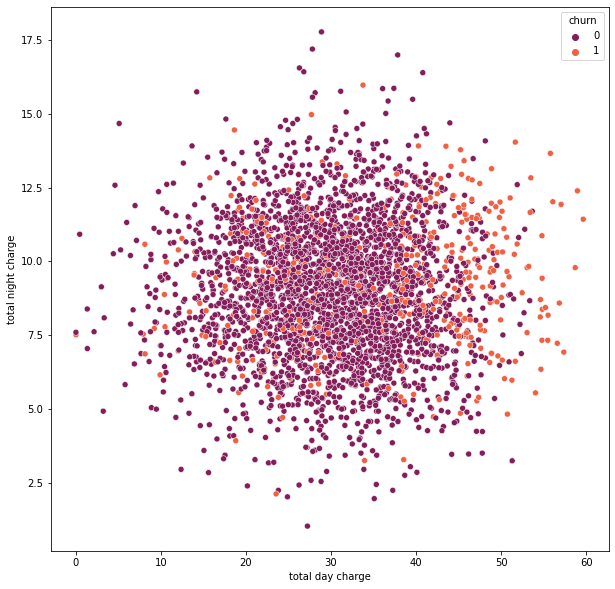

In [69]:
fig_dims = (10, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.scatterplot( ax=ax, data = org_df, x = org_df['total day charge'],\
                y = org_df['total night charge'], hue = org_df['churn'],palette='rocket')
plt.show()

In [64]:
sns.color_palette("coolwarm", as_cmap=True)

<AxesSubplot:xlabel='customer service calls', ylabel='total day charge'>

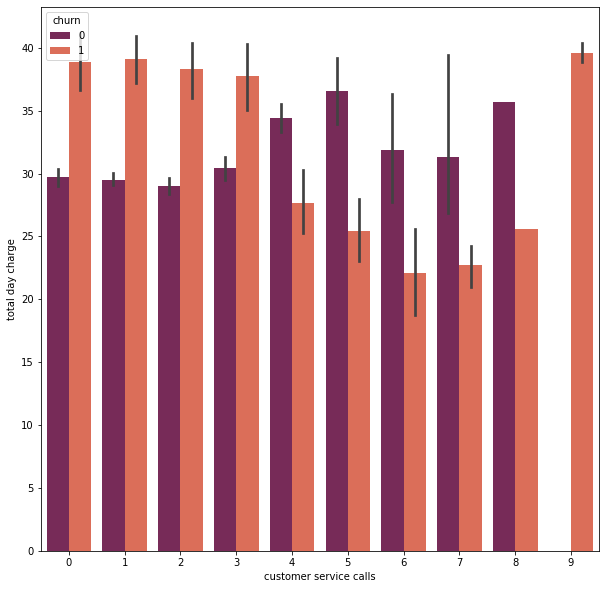

In [68]:
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = 'customer service calls', y = 'total day charge', \
            hue= 'churn', ax=ax, data=org_df, palette='rocket')

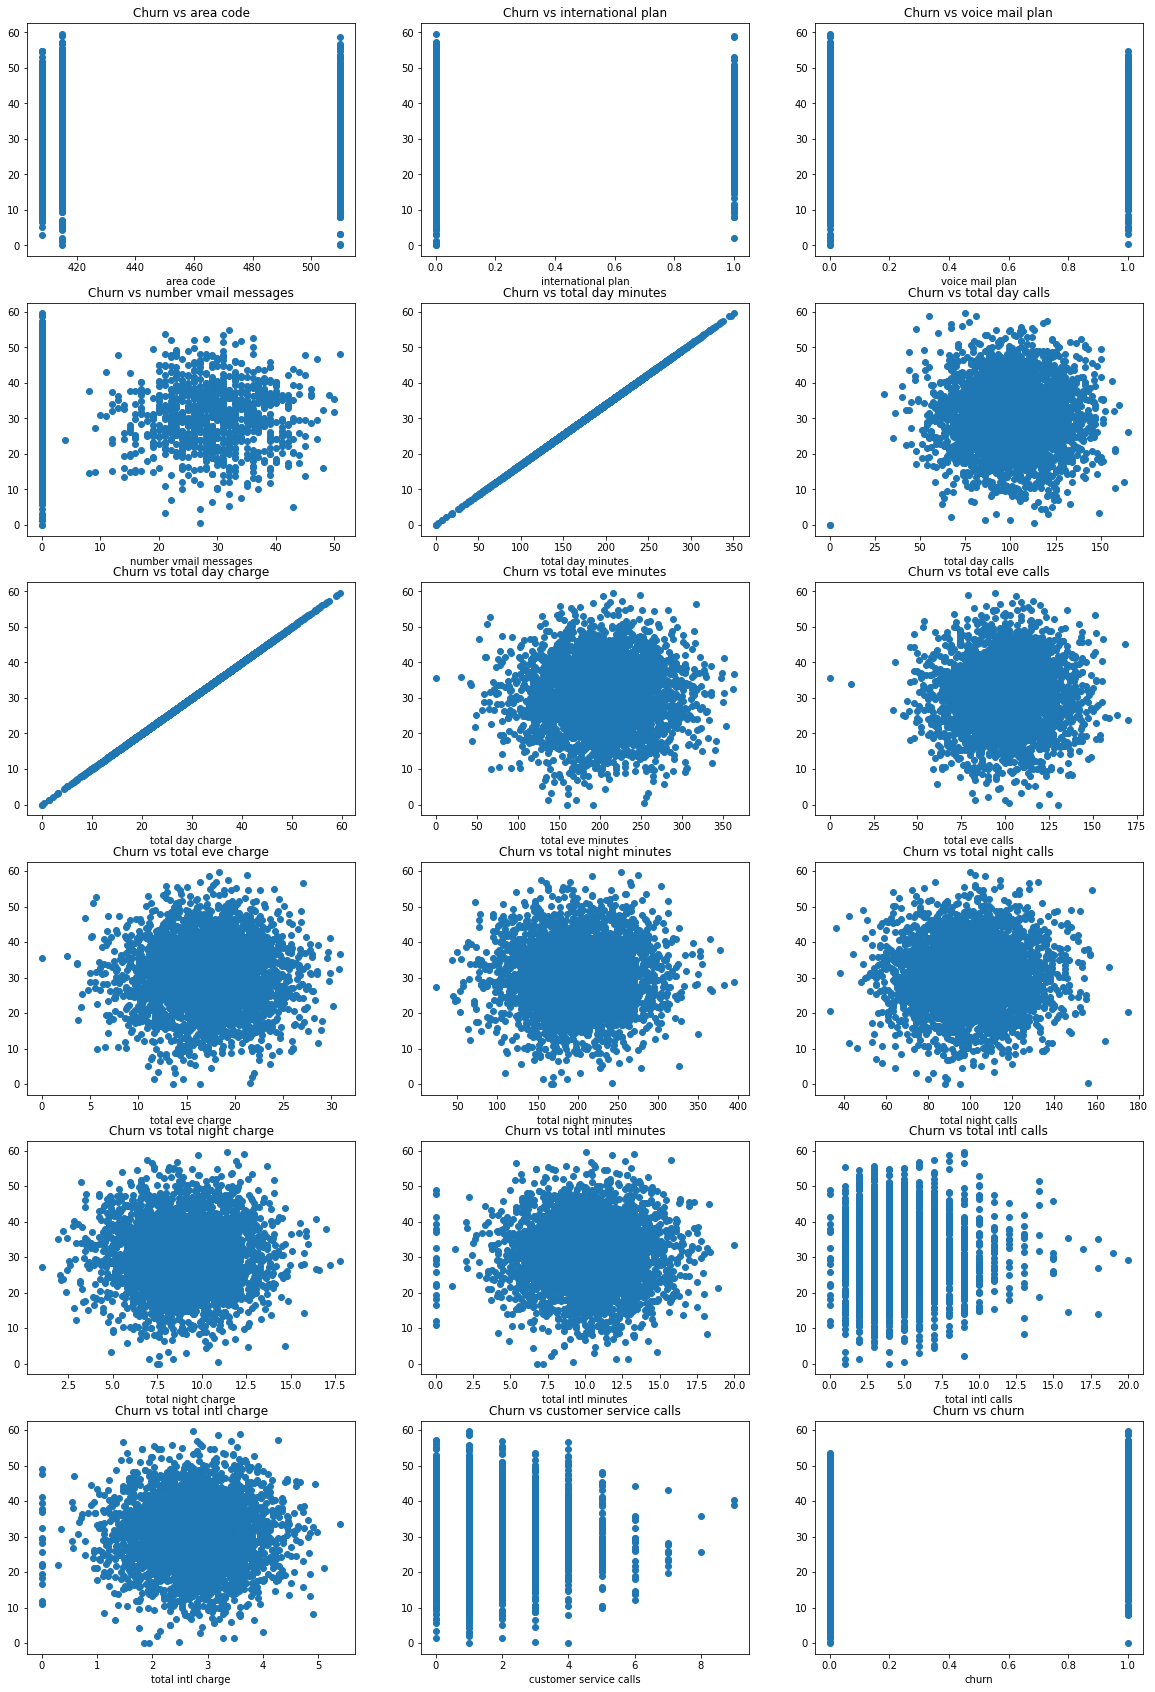

In [82]:
fig, axes = plt.subplots(6, 3, figsize=(20,30))
for ax, column in zip(axes.flatten(), org_df.columns[2:]):
    ax.scatter(org_df[column], org_df['total day charge'], label=column)
    ax.set_title(f'Churn vs {column}')
    ax.set_xlabel(column)

In [ ]:
metrics.plot_confusion_matrix(model, X_test,y_test,cmap=cmap,
                              normalize=normalize, display_labels=labels,ax=ax[0])

## Initial Observations

-I can observe no null values in numerical data but wildly ranged values so scaling will greatly assist in that.

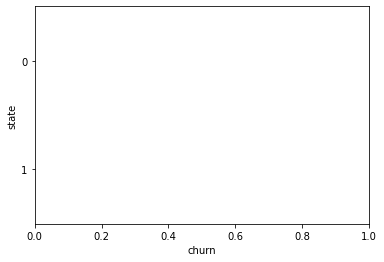

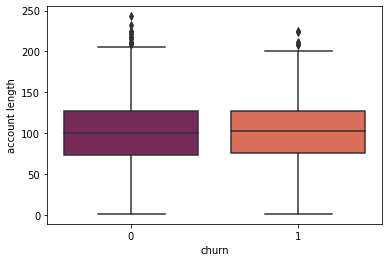

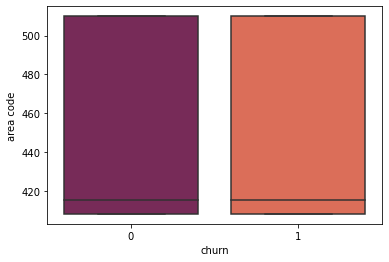

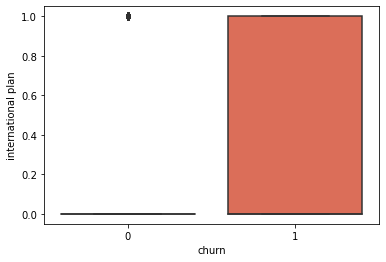

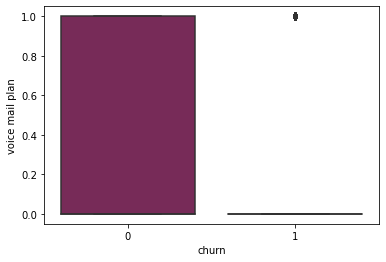

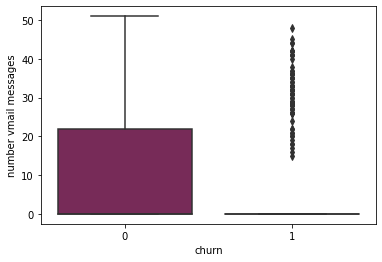

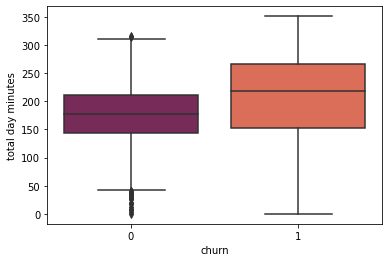

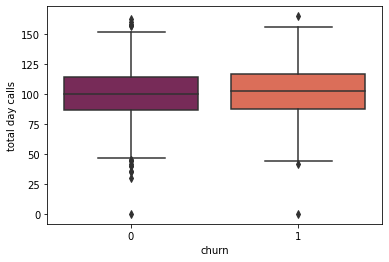

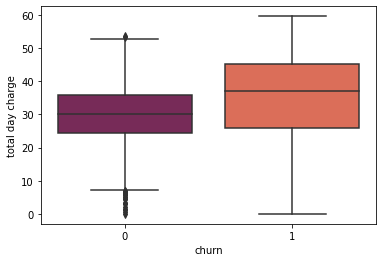

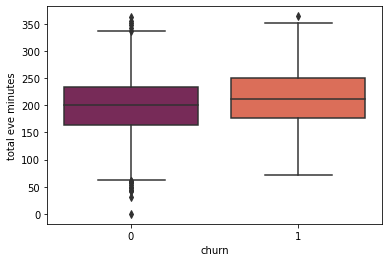

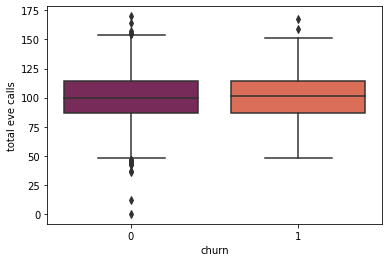

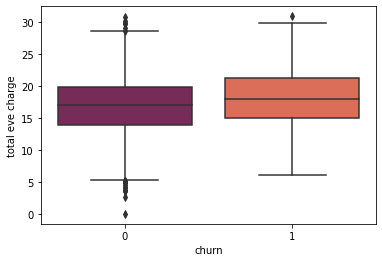

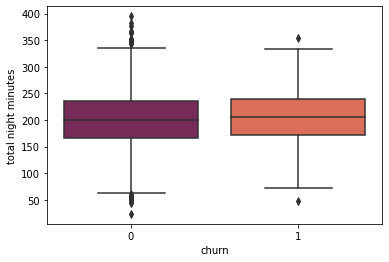

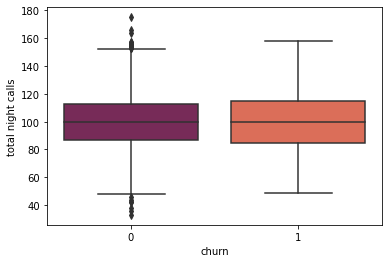

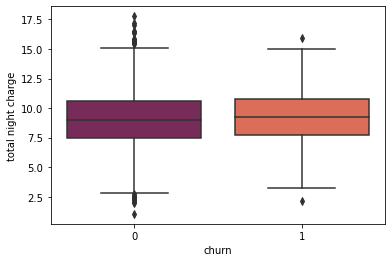

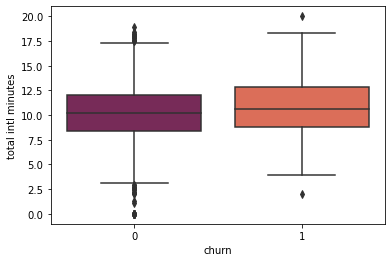

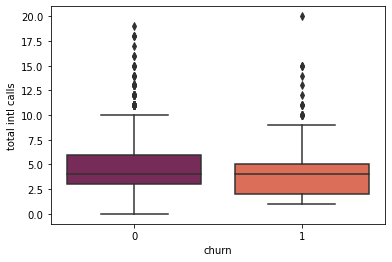

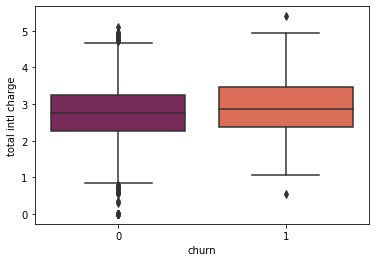

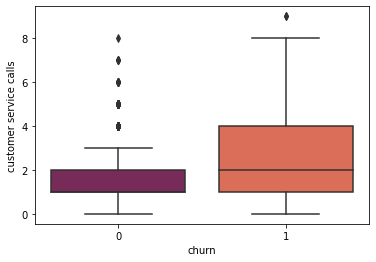

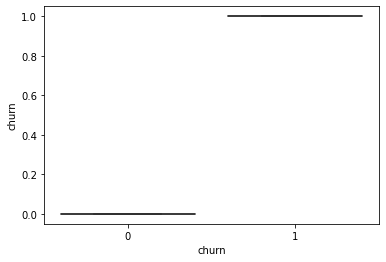

In [70]:
for column in org_df:
    plt.figure()
    ax = sns.boxplot(x="churn", y=column, data=org_df, order=[0, 1], palette='rocket')

In [10]:
corr = org_df.corr()

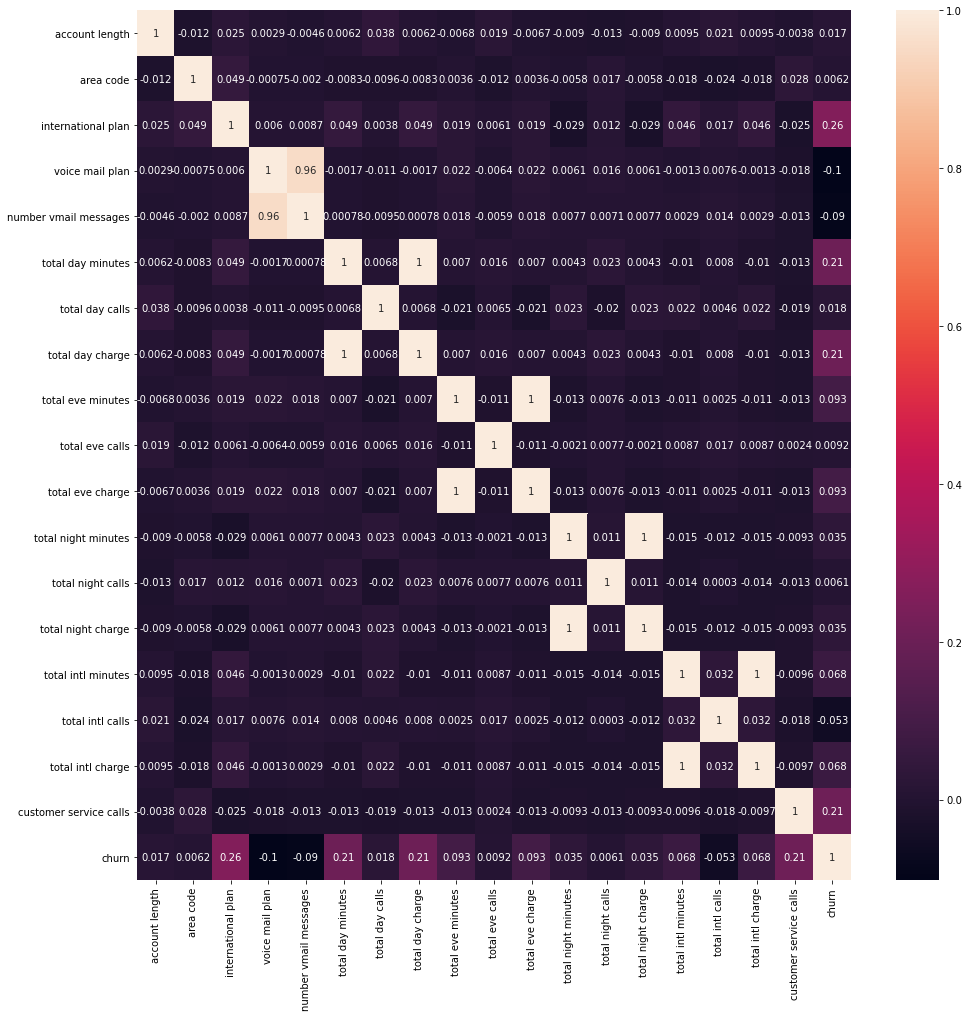

In [73]:
plt.figure(figsize=(16,16))
ax = sns.heatmap(data=corr, cmap="rocket", annot= True)

I'm observing high 1 correlation between minutes and charge so in further EDA I will be dropping those columns.

In [ ]:
def class_eval(model, X_test, y_test, X_train=None, y_train=None,
                    labels=None, cmap='rocket',normalize='true',
                    figsize=(10,4)):
    '''Adapted from:
    https://github.com/jirvingphd/Online-DS-FT-022221-Cohort-Notes/blob/master/Phase_3/topic_25_logistic_regression/topic_25_pt2_LogisticRegression_titanic-v2-SG.ipynb'''
    

    
    print('\n|' + '----'*4 + ' Classification Results ' + '---'*5 + '|'+ '\n')
    
    if (X_train is not None) & (y_train is not None):
        train_score = model.score(X_train, y_train).round(2)
        test_score = model.score(X_test,y_test).round(2)
        difference = train_score - test_score
​
        print(f'Training score: {train_score}')
        print(f'Testing score: {test_score}\n')
​
        if train_score > test_score:
            print(f"The training score is larger by {difference:.2f} points.")
​
        else:
            print(f"The testing score is larger by {difference:.2f} points.")
​
    y_hat_test = model.predict(X_test)
    prob_test = model.predict_proba(X_test)
​
    print(f"\nLog loss: {metrics.log_loss(y_test, prob_test):.2f}\n")
    
    if metrics.log_loss(y_test, prob_test) >= .66:
        print('The log loss is high, indicating a poorly-performing model.')
    elif metrics.log_loss(y_test, prob_test) <= .33:
        print('The log loss is low, indicating a well-performing model.')
    else:
        print('The log loss is moderate, indicating weak model performance.')

    print(metrics.classification_report(y_test, y_hat_test,
                                    target_names=labels))
    print('\n|' + '----'*4 + ' Classification Models ' + '---'*5 + '-|'+ '\n')
​
    fig, ax = plt.subplots(ncols=2, figsize = figsize)

    curve = metrics.plot_roc_curve(model, X_test,y_test,ax=ax[1])
    curve.ax_.grid()
    curve.ax_.plot([0,1],[0,1], ls=':')
    plt.tight_layout()
​
    return None